![](../img/575_banner.png)

# Lecture 4: More HMMs

UBC Master of Data Science program, 2024-25

## Imports, LO

<br><br>

### Imports 

In [1]:
import numpy as np
import pandas as pd
import os.path
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions import *

%matplotlib inline

<br><br>

## Learning outcomes

From this lesson you will be able to

- Describe the purpose and high-level idea of the Viterbi algorithm.
- Identify and explain the three main steps of the Viterbi algorithm, and apply it to a given HMM and observation sequence.
- Compute the values of $\delta_i(t)$ and $\psi_i(t)$ for a specific state $i$ at time step $t$.
- Distinguish between discrete and continuous observation models in the context of HMMs.
- Use the hmmlearn library to perform likelihood computation, sequence decoding, and unsupervised training of HMMs.
- Provide a broad explanation of the concept and components of Markov Decision Processes (MDPs). 

<br><br><br><br>

## Recap

- Hidden Markov models (HMMs) model sequential data with latent factors.
- There are tons of applications associated with them and they are more realistic than Markov models. 

![](../img/HMM_example_small.png)

<!-- <img src="img/HMM_example.png" height="500" width="500"> -->

### HMM ingredients
- Hidden states (e.g., Happy, Sad)
  
- Output alphabet or output symbols or observations (e.g., learn, study, cry, facebook)
- Discrete initial state probability distribution
- Transition probabilities
- Emission probabilities    

The three fundamental questions for an HMM. 

- **Likelihood**
Given a model with parameters $\theta = <\pi, A, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

- **Decoding**
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?

- **Learning**
Training: Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

### Recap: The forward algorithm
- The forward algorithm is a dynamic programming algorithm to efficiently estimate the probability of an observation sequence $P(O;\theta)$ given an HMM.
  
- For each state $i$, we calculated $\alpha_i(0), \alpha_i(1), \alpha_i(2), ...\alpha_i(t)$, which represent the probabilities of being in state $i$ at times $t$ knowing all the observations which came before and at time $t$. 
- The trellis was computed left to right and top to bottom.
- The forward algorithm stores the probabilities of all possible 1-state sequences (from the start), to store all possible 2-state sequences (from the start), to store all possible 3-state sequences (from the start) and so on. 

![](../img/hmm_alpha_values_small.png)

- Sum over all possible final states:
  * $P(O;\theta) = \sum\limits_{i=1}^{n}\alpha_i(T-1)$
  * $P(E,L,F,C) = \alpha_🙂(3) + \alpha_😔(3) = 0.00023 + 0.00207 = 0.0023$ 

<!-- <center> -->
<!-- <img src="img/hmm_alpha_values.png" height="500" width="500">  -->
<!-- </center> -->

Recall the three fundamental questions for an HMM. 

- **Likelihood**
Given a model with parameters $\theta = <\pi, A, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

- **Decoding**
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?

- **Learning**
Training: Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

<br><br><br><br>

## 1. Decoding: The Viterbi algorithm

### 1.1 Introduction

- Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?
  
- Purpose: finding what's most likely going on under the hood. 
- For example: It tells us the most likely part-of-speech tags given an English sentence.

<blockquote>
Will/MD the/DT chair/NN chair/VB the/DT meeting/NN from/IN that/DT chair/NN?
</blockquote>    

More formally, 

- Given an HMM, choose the state sequence that maximizes the probability of the output sequence.
  
 * $Q^* = \arg \max\limits_Q P(O,Q;\theta)$, 
 * $P(O,Q;\theta) = \pi_{q_0}b_{q_0}(o_0) \prod\limits_{t=1}^{T}a_{q_{t-1}}a_{q_t}b_{q_t}(o_t)$
 
![](../img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center> -->

**Can we use the forward algorithm for decoding?**

If we want to pick an optimal state sequence which maximizes the probability of the observation sequence, how about picking the state with maximum $\alpha$ value at each time step? 

Remember that $\alpha_i(t)$ is the total probability of seeing the first $t$ observations and ending up in state $i$ at time $t$, considering all possible paths that could have led there.


![](../img/hmm_alpha_values_small.png)

<!-- <center> -->
<!-- <img src="img/hmm_alpha_values.png" height="500" width="500">  -->
<!-- </center> -->

If we pick the most probable state at each time step based on the $\alpha$ values, it might not end up as the best state sequence because it might be possible that the transition between two highly probable states in a sequence is very unlikely. 

We need something else. 

<br><br>

**The Viterbi algorithm: Overview**

- Dynamic programming algorithm.
  
- We use a different kind of trellis.
  
- Want: Given an HMM, choose the state sequence that maximizes the probability of the output sequence.  
 * $Q^* = \arg \max\limits_Q P(O,Q;\theta)$

- We store $\delta$ and $\psi$ values at each node in the trellis

- $\delta_i(t)$ represents the probability of the **single most probable path** that produces the first $t$ observations and ends in state $i$ at time $t$. 
- $\psi_i(t)$ represents the best possible previous state if I am in state $i$ at time $t$. 

![](../img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center> -->

Let's go through the algorithm step by step. 

<br><br>

### 1.2 Viterbi: Initialization
- Initialize with $\delta_i(0) = \pi_i b_i(o_0)$ for all states
    - $\delta_🙂(0) = \pi_🙂 b_🙂(E) = 0.8 \times 0.2 = 0.16$
    - $\delta_😔(0) = \pi_😔 b_😔(E) = 0.2 \times 0.1 = 0.02$
    
- Initialize with $\psi_i(0) = 0 $, for all states   
    - $\psi_🙂(0) = 0, \psi_😔(0) = 0$

![](../img/HMM_example_trellis.png)
<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center>     -->

<br><br>

### 1.3 Viterbi: Induction

The best path $\delta_t$ to state $j$ at time $t$ depends on the best path to each
possible previous state $\delta_i(t-1)$ and their transitions to $j$ ($a_{ij}$). 

- $\delta_j(t) = \max\limits_i \{\delta_i(t-1)a_{ij}\} b_j(o_t)$
- $\psi_j(t) = \arg \max\limits_i \{\delta_i(t-1)a_{ij}\} $

![](../img/HMM_example_trellis.png)


![](../img/viterbi_explanation_small.png)

<!-- <center> -->
<!-- <img src="img/viterbi_explanation.png" height="150" width="150">  -->
<!-- </center> -->

- There are two possible paths to state 🙂 at $T = 1$. Which is the best one? 
- $\delta_🙂(1) = \max \begin{Bmatrix} \delta_🙂(0) \times a_{🙂🙂},\\ \delta_😔(0) \times a_{😔🙂}\end{Bmatrix}  \times b_🙂(L)$
- First take the max between $\delta_🙂(0) \times a_{🙂🙂}$ and $\delta_😔(0) \times a_{😔🙂}$ and then multiply the max by $b_🙂(L)$.   
    
- $\psi_🙂(1)$ = the state at $T=0$ from where the path to 🙂 at $T=1$ was the best one.     

- **Note that we use parentheses to show two quantities for taking the max. (Not the best notation but I have seen it being used in this context.)**

<br><br>

**Viterbi: Induction (T = 1)**

$\delta$ and $\psi$ at state 🙂 and T = 1
- $\delta_{🙂}(1) = \max\limits_i \{\delta_i(0)a_{ij}\} b_j(o_t) = 
\max \begin{Bmatrix} 0.16 \times 0.7, \\ 0.02 \times 0.4\end{Bmatrix} \times 0.7 = 0.0784$
- $\psi_{🙂}(1) = \arg \max\limits_i \{\delta_i(0)a_{ij}\} = 🙂$

$\delta$ and $\psi$ at state 😔 and T = 1
- $\delta_{😔}(1) = \max\limits_i \{\delta_i(0)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.16 \times 0.3, \\ 0.02 \times 0.6\end{Bmatrix} \times 0.1 = 0.0048$
- $\psi_{😔}(1) = \arg \max\limits_i \{\delta_i(0)a_{ij}\} = 🙂$

![](../img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 1)**

$\delta$ and $\psi$ at state 🙂 and T = 1
- $\delta_{🙂}(1) = \max \begin{Bmatrix} \delta_🙂(0) \times a_{🙂🙂}, \\ \delta_😔(0) \times a_{😔🙂}\end{Bmatrix}  \times b_🙂(L) = 
\max \begin{Bmatrix} 0.16 \times 0.7, \\ 0.02 \times 0.4\end{Bmatrix} \times 0.7 = 0.0784$
- $\psi_{🙂}(1)  = 🙂$

![](../img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 1)**

$\delta$ and $\psi$ at state 😔 and T = 1
- $\delta_{😔}(1) = \max\limits_i \{\delta_i(0)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.16 \times 0.3 ,\\ 0.02 \times 0.6\end{Bmatrix} \times 0.1 = 0.0048$
- $\psi_{😔}(1) = \arg \max\limits_i \{\delta_i(0)a_{ij}\} = 🙂$

![](../img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 2)**

- $\delta$ and $\psi$ at state 🙂 and T = 2
    - $\delta_{🙂}(2) = \max\limits_i \{\delta_i(1)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.784 \times 0.7, \\ 0.0048 \times 0.4 \end{Bmatrix}\times 0 = 0
$
    - $\psi_{🙂}(2) = \arg \max\limits_i \{\delta_i(1)a_{ij}\} = 🙂$

- $\delta$ and $\psi$ at state 😔 and T = 2
    - $\delta_{😔}(2) = \max\limits_i \{\delta_i(1)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.784 \times 0.3, \\ 0.0048 \times 0.6 \end{Bmatrix}\times 0.2 = 4.704 \times 10^{-3}$
    - $\psi_{😔}(2) = \arg \max\limits_i \{\delta_i(1)a_{ij}\} = 🙂$

<br>

**Viterbi: Induction (T = 3)**

- $\delta$ and $\psi$ at state 🙂 and T = 3
    - $\delta_{🙂}(3) = \max\limits_i \{\delta_i(2)a_{ij}\} b_j(o_t) = \max \begin{Bmatrix} 0 \times 0.7, \\ 4.704 \times 10^{-3} \times 0.4 \end{Bmatrix} \times 0.1 = 1.88\times10^{-4}
$
    - $\psi_{🙂}(3) = \arg \max\limits_i \{\delta_i(2)a_{ij}\} = 😔$

- $\delta$ and $\psi$ at state 😔 and T = 3
    - $\delta_{😔}(3) = \max\limits_i \{\delta_i(2)a_{ij}\} b_j(o_t) = \max \begin{Bmatrix} 0 \times 0.3, \\ 4.704 \times 10^{-3} \times 0.6 \end{Bmatrix} \times 0.6 = 1.69 \times 10^{-3}$
    - $\psi_{😔}(3) = \arg \max\limits_i \{\delta_i(2)a_{ij}\} = 😔$

### 1.4 Viterbi conclusion
- Choose the best final state: $q_t^* = \arg \max\limits_i \delta_i(t)$
- Recursively choose the best previous state: $q_{t-1}^* = \psi_{q_t^*}(t)$
    - The most likely state sequence for the observation sequence ELFC is 🙂🙂😔😔.
- The probability of the state sequence is the probability of $q_t^*$
    - $P(🙂🙂😔😔) = 1.69 \times 10^{-3}$    
    
![](../img/HMM_viterbi_conclusion_small.png)

<!-- <img src="img/HMM_viterbi_conclusion.png" height="600" width="600">  -->

<br><br>

### 1.5 Viterbi with [ `hmmlearn`](https://hmmlearn.readthedocs.io) on our toy HMM

![](../img/HMM_example_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_example.png" height="500" width="500">  -->
<!-- </center>     -->

Let's get the optimal state sequence using Viterbi in our toy example.  
- We assume that we already have the model, i.e., transition probabilities, emission probabilities, and initial state probabilities. 
- Our goal is to efficiently find the best state sequence for the given observation sequence. 

In [2]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

# Initializing an HMM
states = ["Happy", "Sad"]
n_states = len(states)

observations = ["Learn", "Eat", "Cry", "Facebook"]
n_observations = len(observations)

# Since we've discrete observations, we'll use `CategoricalHMM`
model = hmm.CategoricalHMM(n_components=n_states)

# Set the initial state probabilities
model.startprob_ = np.array([0.8, 0.2])

# Set the transition matrix
model.transmat_ = np.array([[0.7, 0.3], [0.4, 0.6]])

# Set the emission probabilities of shape (n_components, n_symbols)
model.emissionprob_ = np.array([[0.7, 0.2, 0.1, 0.0], [0.1, 0.1, 0.6, 0.2]])

In [3]:
def get_state_seq(model, observation_seq, states=states, symbols=observations):
    logprob, state_seq = model.decode(observation_seq, algorithm="viterbi")
    o_seq = map(lambda x: symbols[x], observation_seq.T[0])
    s_seq = map(lambda x: states[x], state_seq)
    print("log probability of state sequence: ", logprob)
    return pd.DataFrame(data=s_seq, index=o_seq, columns=["state sequence"])

In [4]:
# Decoding example
toy_seq = np.array([[1], [0], [3], [2]])
get_state_seq(model, toy_seq)

log probability of state sequence:  -6.3809933159177925


,state sequence
Eat,Happy
Learn,Happy
Facebook,Sad
Cry,Sad


- This is how you find the best state sequence that explains the observation sequence using the Viterbi algorithm!
  
- Much faster than the brute force approach of considering all possible state combinations, calculating probabilities for each of them and taking the one resulting in maximum probability. 

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 4.1: Select all of the following statements which are **True** (iClicker)

- (A) In Viterbi, $\delta_i(t)$ is the probability of the best path (i.e., the path with highest probability) which accounts for the first $t$ observations and ending at state $i$.
  
- (B) In Viterbi, suppose at $t-1$, state $i$ has the highest $\delta_i(t-1)$ among all states. Then at time step $t$, the path from $i$ at $t-1$ is going to give us the highest $\delta_j(t)$ for all states $j$ at time $t$.
- (C) In Viterbi, the $\psi_j(t)$ keeps track of the state from the previous time step which results in highest $\delta_i(t-1)a_{ij}$ so that we can keep track of where we came from and we can recreate the path. 

```{admonition} Exercise 4.1: V's Solutions!
:class: tip, dropdown

- (A) True
- (B) False. This will also depend upon the transition probabilities between states.
- (C) True
```

<br><br><br><br>

## 3. Training of HMMs 

Given a large observation sequence (or a set of observation sequences) $O$ for training, but **not** the state sequence, how do we choose the "best" parameters $\theta$ that explain the data $O$? 

We want our parameters $\theta$ to be set so that the available training data is maximally likely. 

**Can we use MLE?**

- If the training data contained state sequences, we could simply do maximum likelihood estimation, as we did in the last lecture, to get transition probabilities and the emission probabilities.
  
- But when we are only given observations, we **cannot** count the following: 
    -  How often we move from $q_{i-1}$ to $q_i$ normalized by how often we move from $q_{i-1}$ to anything: 
      $p(q_i|q_{i-1}) = \frac{Count(q_{i-1} q_i)}{Count(q_{i-1} \text{ANY STATE })}$
    - What's the proportion of $q_i$ emitting the observation $o_i$ .   
      $p(o_i|q_{i}) = \frac{Count(o_i \text{ and } q_i)}{Count(q_{i})}$

- In many cases, the mapping between hidden states and observations is unknown and so we can't use MLE.      
- How to deal with the incomplete data?
    - Use an iterative unsupervised approach (expectation-maximization)
    - We won't go into the details. If you are interested in knowing more, checkout [AppendixA](AppendixA-BaumWelch.ipynb). 

<br><br>

**Using HMMs with `hmmlearn`**

Let's try out HMM decoding and learning with `hmmlearn`. 

In [5]:
import numpy as np
import pandas as pd
import random
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Define states and observations
states = ["Happy", "Sad"]
observations = ["Learn", "Eat", "Cry", "Facebook"]
state_map = {i: s for i, s in enumerate(states)}
obs_map = {i: o for i, o in enumerate(observations)}

# Define HMM parameters
true_model = hmm.CategoricalHMM(n_components=2, random_state=42)
true_model.startprob_ = np.array([0.8, 0.2])
true_model.transmat_ = np.array([[0.7, 0.3],
                                 [0.4, 0.6]])
true_model.emissionprob_ = np.array([[0.7, 0.2, 0.1, 0.0],
                                     [0.1, 0.1, 0.6, 0.2]])

# Generate sequences
n_sequences = 50
lengths = [random.randint(60, 100) for _ in range(n_sequences)]
total_length = sum(lengths)
X, Z = true_model.sample(total_length)
X = X.reshape(-1, 1)
X.shape

(3878, 1)

Let's train an unsupervised HMM on these sampled sequences. 

In [6]:
# Fit multiple unsupervised models and pick best
best_score = -np.inf
best_model = None

for seed in range(10):
    model = hmm.CategoricalHMM(n_components=2, n_iter=100, random_state=seed)
    model.fit(X, lengths) # Pass X and seqlens 
    score = model.score(X, lengths)
    if score > best_score:
        best_model = model
        best_score = score

Nodes:
['s0', 's1']



/Users/kvarada/miniforge3/envs/575/lib/python3.12/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning:





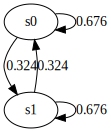

In [7]:
visualize_hmm(best_model)

In [8]:
# Compare parameters
def print_comparison(true, learned, labels):
    df = pd.DataFrame({
        "True": pd.Series(true, index=labels),
        "Learned": pd.Series(learned, index=labels)
    })
    return df

print("Start Probabilities")
display(print_comparison(true_model.startprob_, best_model.startprob_, states))

print("\n\n")
trans_df = pd.DataFrame(true_model.transmat_, columns=states, index=states)

print("🔹 TRUE trasition matrix")
trans_learned_df = pd.DataFrame(best_model.transmat_, columns=states, index=states)
display(trans_df)

print("🔹 LEARNED transition matrix")
display(trans_learned_df)

print("\n\n")

emission_df = pd.DataFrame(true_model.emissionprob_, columns=observations, index=states)
emission_learned_df = pd.DataFrame(best_model.emissionprob_, columns=observations, index=states)

print("🔹 TRUE Emission Probabilities")
display(emission_df)

print("🔹 LEARNED Emission Probabilities")
display(emission_learned_df)

Start Probabilities


,True,Learned
Happy,0.8,0.613061
Sad,0.2,0.386939





🔹 TRUE trasition matrix


,Happy,Sad
Happy,0.7,0.3
Sad,0.4,0.6


🔹 LEARNED transition matrix


,Happy,Sad
Happy,0.676160,0.323840
Sad,0.324273,0.675727





🔹 TRUE Emission Probabilities


,Learn,Eat,Cry,Facebook
Happy,0.7,0.2,0.1,0.0
Sad,0.1,0.1,0.6,0.2


🔹 LEARNED Emission Probabilities


,Learn,Eat,Cry,Facebook
Happy,0.689693,0.218369,0.089759,0.002178
Sad,0.207104,0.099313,0.531054,0.162528


Compare it with our toy HMM

![](../img/HMM_example_trellis.png)

<!-- <img src="img/HMM_example_trellis.png" height="600" width="600">  -->

- The model is close to the real model from which we have sampled the sequences. 
- Note that it's an unsupervised model and it doesn't give you interpretation of the states. You have to do it on your own. 

<br><br>

### Continuous HMMs

- If the observations are drawn from a continuous space (e.g., speech), the probabilities must be continuous as well.
  
- HMMs generalize to continuous probability distributions.

- In the lab your observations are mfcc feature vectors for time frames which are continuous observations. 
- In `hmmlearn` you can use `GaussianHMM` or `GMMHMM` for continuous observations. 

Let's extend our toy HMM into a continuous HMM demo using GaussianHMM from hmmlearn.

- Instead of discrete observations like "Eat" or "Cry", we now observe continuous sensor values, e.g., from an accelerometer or heart rate monitor. Each hidden state (e.g., Happy, Sad) emits a Gaussian-distributed real number (or vector).

<!-- ![](../img/continuous_hmms.png) -->

<img src="../img/continuous_hmms.png" height="400" width="400">       


- Hidden states: "Happy" and "Sad"
- Observed data: 1D continuous values representing a mood-related sensor signal

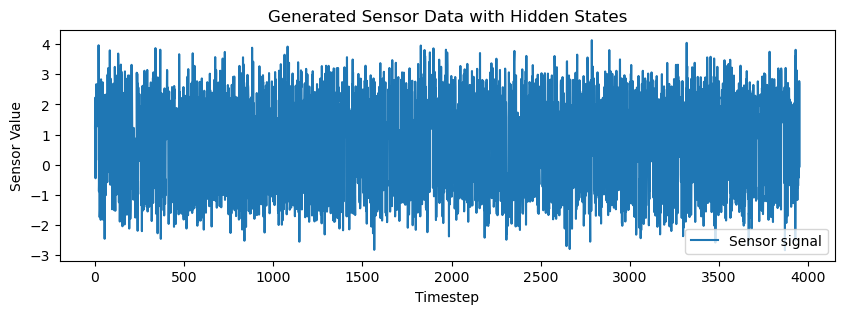

True Means:
 [ 2. -1.]
Learned Means:
 [-1.01501658  1.99077979]

True Covariances:
 [0.5 0.3]
Learned Covariances:
 [0.3095461  0.49688438]

True Transitions:
 [[0.7 0.3]
 [0.4 0.6]]
Learned Transitions:
 [[0.59659226 0.40340774]
 [0.28473954 0.71526046]]


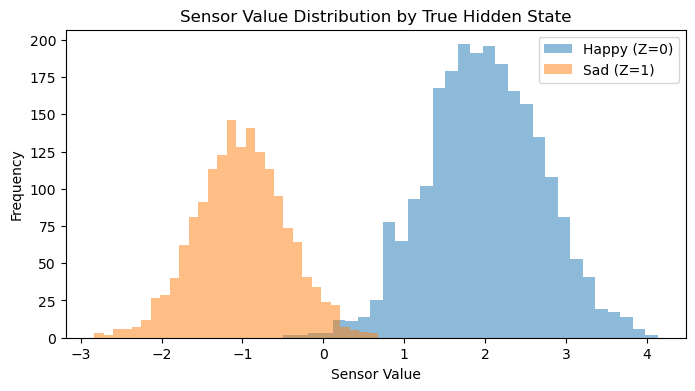

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Set random seed
np.random.seed(42)

# Define hidden states and parameters
states = ["Happy", "Sad"]
n_states = len(states)

# Define Gaussian HMM
model_true = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=100, random_state=42)

model_true.startprob_ = np.array([0.8, 0.2])
model_true.transmat_ = np.array([[0.7, 0.3],
                                 [0.4, 0.6]])
model_true.means_ = np.array([[2.0],  # Happy
                              [-1.0]])  # Sad
model_true.covars_ = np.array([[0.5], [0.3]])

# Generate synthetic data
n_sequences = 50
seqlens = [np.random.randint(60, 100) for _ in range(n_sequences)]
X, Z = model_true.sample(sum(seqlens))

# Plot the generated sequence and hidden states
plt.figure(figsize=(10, 3))
plt.plot(X, label='Sensor signal')
plt.title("Generated Sensor Data with Hidden States")
plt.xlabel("Timestep")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

# Fit a GaussianHMM on the data
model_unsup = hmm.GaussianHMM(n_components=2, covariance_type='diag', n_iter=100, random_state=0)
model_unsup.fit(X, seqlens)

# Compare parameters
print("True Means:\n", model_true.means_.ravel())
print("Learned Means:\n", model_unsup.means_.ravel())

print("\nTrue Covariances:\n", model_true.covars_.ravel())
print("Learned Covariances:\n", model_unsup.covars_.ravel())

print("\nTrue Transitions:\n", model_true.transmat_)
print("Learned Transitions:\n", model_unsup.transmat_)

# Plot histogram of sensor values colored by true hidden state
plt.figure(figsize=(8, 4))
plt.hist(X[Z==0], bins=30, alpha=0.5, label="Happy (Z=0)")
plt.hist(X[Z==1], bins=30, alpha=0.5, label="Sad (Z=1)")
plt.title("Sensor Value Distribution by True Hidden State")
plt.xlabel("Sensor Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

<br><br>

## 4. From HMMs to Markov Decision Processes (MDPs)

Now that we've explored Hidden Markov Models (HMMs), which model sequences where the system is assumed to be a Markov process with unobserved (hidden) states, we can zoom out to a broader and more action-oriented framework: the Markov Decision Process (MDP).

### Getting to Whistler on a Friday Night in Winter 🏔️

Suppose you want to get to Whistler as quickly as possible (i.e., minimize total travel time) despite unpredictable winter conditions. Pick one of the following possible choices:

- (A) Drive
- (B) Bus 
- (C) Seaplane
- (D) Fly

- (E) Bike 

<br><br><br><br>


The world is full of uncertainties, and we constantly make decisions without knowing exactly how things will turn out.

You might take an action expecting one result, but something else happens. Maybe you chose to take the seaplane to Whistler and it got canceled last minute. Or you studied late expecting to feel confident, but ended up too tired to focus. These mismatches between action and outcome happen all the time.

We use Markov Decision Processes (MDPs) to model these uncertainties and plan under them.

The goal in a Markov Decision Process (MDP) is to find or learn a policy, a strategy for choosing actions, that maximizes the expected cumulative reward over time. MDPs are the foundation of **Reinforcement Learning** (RL), which is about learning how to make better decisions by trying things out and getting feedback, rewards when things go well, penalties when they don't, so over time, the system improves its behaviour.

![](../img/agent-environment-interaction-loop.png)

[Source](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#id4)

**What is an MDP?**

An MDP models decision-making in environments that evolve over time in a stochastic (i.e., probabilistic) way. Formally, an MDP is defined by:
- States $s \in \mathcal{S}$: the situation the agent is in (analogous to HMM states).
  
- Actions $a \in \mathcal{A}$: choices the agent can make.
- Transition probabilities $P(s^{\prime} \mid s, a)$: how likely the next state $s^\prime$ is, given the current state $s$ and chosen action $a$.
- Rewards $R(s, a)$: how good or bad the action $a$ was in state $s$.
- Policy $\pi(a \mid s)$: a rule used by an agent to decide what actions $a$ to take at state $s$. 

**A simple example**

Let's extend our toy example to an MDP. 

In the HMM version:
- The system (person) moves between hidden mood states: Happy (🙂), Sad (😔)
- You observe activities like: Learn, Eat, Cry, Facebook


Now imagine you're a virtual assistant or wellness app trying to help the person stay Happy over time. Each day, you suggest an action, and depending on the person's current mood, the action affects:
- Their next mood
  
- The reward they get (i.e., how helpful that action was)

![](../img/MDP-example.png)

- **States $S$**: Happy (🙂), Sad (😔)
  
- **Actions $A$**: Learn, Eat, Cry, Facebook
- **Transition probabilities $P(s^{\prime} \mid s,a)$**: how likely the next state is, given the current state and chosen action.
    - $P(🙂 \mid 🙂, L) = 0.8$
    - $P(🙂 \mid 😔 , L) = 0.3$
- **Rewards $R(s,a)$**: how good or bad the action was in that state.
    - $R(🙂, Learn) = 2$
    - $R(😔, Learn) = -1$   
- **Policy $\pi$**: a strategy that tells the agent what action to take in each state.
    - If in 😊 $\rightarrow$ Do Learn
    - If in 😢 $\rightarrow$ Do Eat 

Note that we haven't included an END state here because we're modeling daily mood dynamics as an ongoing process, like how your behaviour today affects your mood tomorrow, and so on. But if we wanted to model a finite episode, like a 5-day challenge to improve your mood, or burnout after too much Facebook, we could add a terminal END state.

**Markov Property in HMMs and MDPs**

Both HMMs and MDPs rely on the Markov assumption, which means that the future is independent of the past given the present. 

- In HMMs:
$$P(s_{t+1} \mid s_t, s_{t-1}, s_{t-2}, \dots) = P(s_{t+1} \mid s_{t})$$

- In MDPs:
$$P(s_{t+1} \mid s_t, a_t, s_{t-1}, a_{t-1}, \dots) = P(s_{t+1} \mid s_t, a_t)$$

This assumption is what allows these models to be tractable and scalable and opens the door for efficient learning and planning algorithms.
<br><br>

**(optional) Motivation: How are LLMs actually trained?**

- So far, we've seen HMMs as passive predictors of sequences, and MDPs as frameworks for taking actions to maximize reward. But where does this fit in the world of Large Language Models (LLMs)?

- Large language models like ChatGPT are initially trained to predict the next word in a sequence (just like a probabilistic language model).
  
- But that alone doesn't make them **helpful**.

- To align LLM behaviour with human preferences, LLMs go through a second training phase called **Reinforcement Learning with Human Feedback (RLHF)**. This process:

    - Trains a reward model to reflect human preferences
      
	- Fine-tunes the model using reinforcement learning, rooted in MDPs
 
 In the context of LLMs,  
- State ($S$): The prompt or conversation history given to the LLM.
  
- Action ($A$): The generated word or response
- Policy ($\pi$): The model's probability distribution over possible responses, fine-tuned to align with human preferences.
- Reward ($R$): A score based on helpfulness, correctness, tone (from human or reward model)
- Transition ($T$): How the state updates after generating a response

In small MDPs like our emoji mood world, we can draw every state and arrow. But with LLMs, it's like the state space is the entire internet, and the actions are every possible English sentence. So we approximate the MDP using neural networks instead of drawing diagrams or tables.

**Take away**

You don't need to dive deep into RL or MDPs now, but know that your understanding of Markov chains and HMMs gives you a solid foundation. These models are stepping stones to more advanced topics like:
- Reinforcement learning
  
- Policy optimization
- Training aligned AI systems


<br><br><br><br>

## Final comments and summary

- Hidden Markov Models (HMMs) provide a probabilistic framework to model sequences. 
- They are much more practical compared to Markov models and are widely used. 
- Speech recognition is a success story for HMMs. 

### Three fundamental questions for HMMs

**Likelihood**: Given a model with parameters $\theta = <\pi, A, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

**Decoding**
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?

**Learning**
Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

### Important ideas to know

- The definition of an HMM
- The conditional independence assumptions of an HMM
- The purpose of the forward algorithm.
    - How to compute $\alpha_i(t)$
- The purpose of the Viterbi algorithm.
    - How to compute $\delta_i(t)$ and $\psi_i(t)$
- Definition of Markov Decision Processes (MDPs)

### Important ideas to know 

Using `hmmlearn` 
- For unsupervised training of HMMs. 
- For likelihood (`model.score`)    
- For decoding (`model.decode`)
- For discrete observations (`MultinomialHMM`)
- For continuous observations (`GaussianHMM` or `GMMHMM`)
- For sequences with varying lengths.  

<br><br><br><br>

### Some useful resources and links 
- [Frank Rudzicz's slides on HMM](http://www.cs.toronto.edu/~frank/csc401/lectures2020/5_HMMs.pdf) 
- [Andrew McCallum's slides on HMM](https://people.cs.umass.edu/~mccallum/courses/inlp2004a/lect10-hmm2.pdf)
- [A wonderful video on MDPs](https://www.youtube.com/watch?v=9g32v7bK3Co&list=PLot0TjjdZHmov4JDYex-9-Fv2VKmMneKZ)

<br><br><br><br>

## ❓❓ Questions for you

### (Optional) Exercise 4.2: More practice questions

Discuss the following questions with your neighbour. 

Consider the sentence below:
<blockquote>
    Will the chair chair the meeting from this chair ?
</blockquote>

and a simple part-of-speech tagset: 
<blockquote>
{noun, verb, determiner, preposition, punctuation}
</blockquote>    

The table below shows the possible assignments for words and part-of-speech tags. The symbol `x` denotes that the word and part-of-speech tag combination is possible. For instance, the word _chair_ is unlikely to be used as a determiner and so we do not have an `x` there. 

|    <i></i>    | Will    | the     | chair   | chair   | the     | meeting  | from    | this    | chair   | ?       |
| ------------- | :-----: | :-----: | :-----: | :-----: | :----:  | :------: | :-----: | :-----: | :-----: | :----:  |
| noun          | x       | x       |  x      | x       | x       | x        | <i></i> | <i></i> | x       | <i></i> |
| verb          | x       | <i></i> |  x      | x       | <i></i> | x        | <i></i> | <i></i> | x       | <i></i> |
| determiner    | <i></i> | x       | <i></i> | <i></i> | x       | <i></i>  | <i></i> | x       | <i></i> | <i></i> |
| preposition   | <i></i> | <i></i> | <i></i> | <i></i> | <i></i> | <i></i>  | x       | <i></i> | <i></i> | <i></i> |
| punctuation   | <i></i> | <i></i> | <i></i> | <i></i> | <i></i> | <i></i>  | <i></i> | <i></i> | <i></i> | x       |


Given this information, answer the following questions: 
- (A) With this simple tagset of part-of-speech tags, how many possible part-of-speech tag sequences (i.e, hidden state sequences) are there for the given sentence (observation sequence)?
- (B) Restricting to the possibilities shown above with `x`, how many possible part-of-speech tag sequences are there?
- (C) Given an HMM with states as part-of-speech tags and observations as words, one way to decode the observation sequence is using the brute force method below. What is the time complexity of this method in terms of the number of states ($n$) and the length of the output sequence ($T$)? You may ignore constants.    
    - enumerate all possible hidden state sequences (i.e., enumerate all solutions)
    - for each hidden state sequence, calculate the probability of the observation sequence given the hidden state sequence (i.e., score each solution)
    - pick the hidden state sequence which gives the highest probability for the observation sequence (i.e., pick the best solution)    

- (D) If you decode the sequence using the Viterbi algorithm instead, what will be the time complexity in terms of the number of states ($n$) and the length of the output sequence ($T$)? You may ignore constants.    

```{admonition} Exercise 4.2: V's Solutions!
:class: tip, dropdown
```